# 04 - Vertex AI > Notebooks - Models Built in Notebooks with sklearn

*This notebook was developed in collaboration with [statmike](https://github.com/statmike), basing much of the core code from existing notebooks and extending to new features. Notebook author: [goodrules](https://github.com/goodrules)*

Where a model gets trained is where it consumes computing resources.  With Vertex AI, you have choices for configuring the computing resources available at training.  This notebook is an example of an execution environment.  When it was set up there were choices for machine type and accelerators (GPUs).  

This notebook shows training a model directly within the runtime of the notebook environment.  Then the model is saved and moved to GCS for deployment to a Vertex AI > Endpoint for online predictions.  The model training is done with [sklearn](https://scikit-learn.org/stable/) and was designed to show a standard approach to logistic regression.  The training data batches are read from BigQuery using the [BigQuery Client](https://googleapis.dev/python/bigquery/latest/index.html).


The other notebooks in this series (`06a-06i`) show how to move the training into a managed compute environment using Vertex AI > Training.

### Video Walkthrough of this notebook:
Includes conversational walkthrough and more explanatory information than the notebook:

WIP

### Prerequisites:
-  01 - BigQuery - Table Data Source

### Overview (update once code is complete):
-  Use Python Client for BigQuery
   -  Read the tables schema from BigQuery INFORMATION_SCHEMA
   -  Prepare the feature information for sklearn
-  Demonstrate reading a single batch
-  Train an SKLearn model
   -  Define the parameter search grid
   -  Execute the model grid search
   -  Evaluate the models (accuracy)
   -  Select the best model
   -  Create prediction with the model
-  Use Python Client google.cloud.aiplatform for Vertex AI
   -  Upload Model
      -  Model - aiplatform.Model.upoad
   -  Create Endpoint
      -  Endpoint - aiplatform.Endpoint.create
   -  Deploy to Endpoint
      -  Endpoint.deploy(model=Model)
   -  Online Predictions
      -  Endpoint.predict
-  Online Predictions with:
   -  REST call
   -  gcloud CLI

### Resources:
-  [sklearn](https://scikit-learn.org/stable/)
-  [Python Client For Google BigQuery](https://googleapis.dev/python/bigquery/latest/index.html)
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  Pre-built Containers for Vertex AI
    - [Training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers)
    - [Prediction & Explaination](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)


---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/05_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/05_console.png">

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'mg-ce-demos'

In [2]:
REGION = 'us-central1'
DATANAME = 'fraud'
NOTEBOOK = '04'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'
DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-23:latest'
TRAINING_IMAGE = 'us-docker.pkg.dev/vertex-ai/training/sklearn-cpu.0-23:latest'
SKLEARN_VERSION = '0.23'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = ['transaction_id', 'Class', 'splits'] # add more variables to the list


packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import joblib
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import json

from datetime import datetime
import os

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


clients:

In [4]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

environment:

In [6]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Training Data
In this exercise the data source is a table in Google BigQuery.  While it is possible to bring the entire table into the local notebook as a Pandas dataframe, it is not a scalable solution for very large training tables.

### Data Schema
Using BigQueries Information_Schema is an easy way to quickly retrieve the column information about our training data.  In this case we need the column names and data types to setup the data reading and the model inputs.  This section retrieves the column information for the training table source.

In [7]:
query = f"SELECT * FROM {DATANAME}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{DATANAME}_prepped'"
schema = bigquery.query(query).to_dataframe()
schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name,column_default,rounding_mode
0,mg-ce-demos,fraud,fraud_prepped,Time,1,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None
1,mg-ce-demos,fraud,fraud_prepped,V1,2,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None
2,mg-ce-demos,fraud,fraud_prepped,V2,3,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None
3,mg-ce-demos,fraud,fraud_prepped,V3,4,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None
4,mg-ce-demos,fraud,fraud_prepped,V4,5,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None
5,mg-ce-demos,fraud,fraud_prepped,V5,6,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None
6,mg-ce-demos,fraud,fraud_prepped,V6,7,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None
7,mg-ce-demos,fraud,fraud_prepped,V7,8,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None
8,mg-ce-demos,fraud,fraud_prepped,V8,9,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None
9,mg-ce-demos,fraud,fraud_prepped,V9,10,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL,None


### Number of Classes for the Label Column: VAR_TARGET
This is a supervised learning example that classifies examples into the classes found in the label column stored in the variable `VAR_TARGET`.

In [8]:
nclasses = bigquery.query(query = f'SELECT DISTINCT {VAR_TARGET} FROM {DATANAME}.{DATANAME}_prepped WHERE {VAR_TARGET} is not null').to_dataframe()
nclasses

,Class
0,0
1,1


In [9]:
nclasses = nclasses.shape[0]
nclasses

2

---
## Read From BigQuery

In [38]:
train_query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits = 'TRAIN'"
train = bigquery.query(train_query).to_dataframe()
X_train = train.loc[:, ~train.columns.isin(VAR_OMIT)]
y_train = train[VAR_TARGET]

In [12]:
val_query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits = 'VALIDATE'"
val = bigquery.query(val_query).to_dataframe()
X_val = val.loc[:, ~val.columns.isin(VAR_OMIT)]
y_val = val[VAR_TARGET]

In [13]:
test_query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits = 'TEST'"
test = bigquery.query(test_query).to_dataframe()
X_test = test.loc[:, ~test.columns.isin(VAR_OMIT)]
y_test = test[VAR_TARGET]

---
## Train the Model In The Notebook (local runtime)

This example uses a grid search cross validation ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV)) to test multiple combinations of solvers, penalties, and C values to determine the best Logistic Regression model, scoring for accuracy ([sklearn logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).  

Warning The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:
- ‘newton-cg’ - [‘l2’, ‘none’]
- ‘lbfgs’ - [‘l2’, ‘none’]
- ‘liblinear’ - [‘l1’, ‘l2’]
- ‘sag’ - [‘l2’, ‘none’]
- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

In [14]:
# instantiate the model 
clf = LogisticRegression(random_state=18)

# define parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10, 1.0, 0.1,] # can use more values of C (e.g. 100, .01)


In [15]:
# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)

# fit model
model_grid_search = grid_search.fit(X_train, y_train) #stores the best model when called, can also search results of other combinations (see below)


/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mikegoodman/Documents/developer/v

Evaluate the training models:

In [16]:
# summarize grid search results
print("Best: %f using %s" % (model_grid_search.best_score_, model_grid_search.best_params_))
means = model_grid_search.cv_results_['mean_test_score']
stds = model_grid_search.cv_results_['std_test_score']
params = model_grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.999179 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999178 (0.000154) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998941 (0.000182) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.998938 (0.000185) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.999179 (0.000155) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998935 (0.000196) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.998937 (0.000182) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.999171 (0.000157) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998916 (0.000176) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.998918 (0.000177) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [17]:
# select best model
model = model_grid_search.best_estimator_
model

LogisticRegression(random_state=18, solver='newton-cg')

Evaluate using validation and test data on the best model:

In [18]:
model.score(X_val, y_val) # mean accuracy for validation set

0.999015678830064

In [19]:
model.score(X_test, y_test) # mean accuracy for test set

0.9991217901429725

Create Prediction from a batch of the test data and review confusion matrix:

In [20]:
y_pred = model.predict(X_test) # predictions using best model

Text(0.5, 257.44, 'Predicted label')

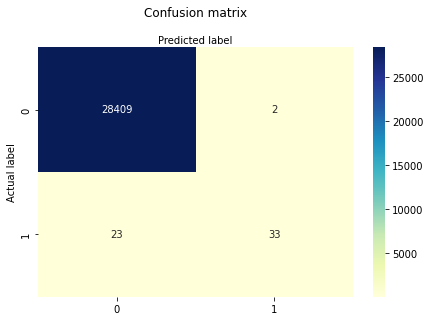

In [21]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

class_names = [0,1] # name  of classes 
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

In [22]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 
print("Precision:",metrics.precision_score(y_test, y_pred)) 
print("Recall:",metrics.recall_score(y_test, y_pred)) 

Accuracy: 0.9991217901429725
Precision: 0.9428571428571428
Recall: 0.5892857142857143


---
## Serving

### Save The Model

In [23]:
!mkdir model_artifacts
joblib.dump(model, f'model_artifacts/model.joblib') # the model needs to be named model.joblib is order for model upload to be successful


mkdir: model_artifacts: File exists


['model_artifacts/model.joblib']

In [24]:
!gsutil cp model_artifacts/model.joblib {URI}/model.joblib # the model needs to be named model.joblib is order for model upload to be successful




Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Copying file://model_artifacts/model.joblib [Content-Type=application/octet-stream]...
/ [1 files][  1.6 KiB/  1.6 KiB]                                                
Operation completed over 1 objects/1.6 KiB.                                      


In [25]:
# confirm model is in the right bucket
!gsutil ls {URI}

gs://mg-ce-demos/fraud/models/04/model.joblib


### Upload The Model

In [26]:
modelmatch = aiplatform.Model.list(filter = f'display_name="{NOTEBOOK}_{DATANAME}"')
if modelmatch:
    print("Model Already in Registry:")
    if f'time-{TIMESTAMP}' in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        model = aiplatform.Model.upload(
            display_name = f'{NOTEBOOK}_{DATANAME}',
            model_id = f'model_{NOTEBOOK}_{DATANAME}',
            parent_model =  modelmatch[0].resource_name,
            serving_container_image_uri = DEPLOY_IMAGE,
            artifact_uri = f"{URI}",
            #model_file_path = "model_artifacts/model_06_fraud.joblib", # use for upload_scikit_learn_model_file
            #sklearn_version = SKLEARN_VERSION, # use for upload_scikit_learn_model_file
            is_default_version = True,
            version_aliases = [f'time-{TIMESTAMP}'],
            version_description = f'time-{TIMESTAMP}',
            labels = {'notebook':f'{NOTEBOOK}'}        
        )
else:
    print('This is a new model, creating in model registry')
    model = aiplatform.Model.upload(
        display_name = f'{NOTEBOOK}_{DATANAME}',
        model_id = f'model_{NOTEBOOK}_{DATANAME}',
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}",
        #model_file_path = "model_artifacts/model_06_fraud.joblib", # use for upload_scikit_learn_model_file
        #sklearn_version = SKLEARN_VERSION, # use for upload_scikit_learn_model_file
        is_default_version = True,
        version_aliases = [f'time-{TIMESTAMP}'],
        version_description = f'time-{TIMESTAMP}',
        labels = {'notebook':f'{NOTEBOOK}'}
    )     

Model Already in Registry:
Loading model as new default version.
Creating Model
Create Model backing LRO: projects/633472233130/locations/us-central1/models/model_04_fraud/operations/9135945812881178624
Model created. Resource name: projects/633472233130/locations/us-central1/models/4215681512521072640@2
To use this Model in another session:
model = aiplatform.Model('projects/633472233130/locations/us-central1/models/4215681512521072640@2')


In [27]:
# manual check of model in registry
modelmatch = aiplatform.Model.list(filter = f'display_name="{NOTEBOOK}_{DATANAME}"')
if modelmatch:
    print(modelmatch[0].display_name)
    print(modelmatch[0].container_spec)
else:
    print('No model')

04_fraud
image_uri: "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-23:latest"



#### Model.upload wouldn't work for me locally, not sure what the issue is.  Will test from vertex workbench.  Model_file_path only for local upload.

**Note** on Version Aliases:
>Expectation is a name starting with `a-z` that can include `[a-zA-Z0-9-]`

**Retrieve a Model Resource**

[Resource](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)
```Python
model = aiplatform.Model(model_name = f'model_{NOTEBOOK}_{DATANAME}') # retrieves default version
model = aiplatform.Model(model_name = f'model_{NOTEBOOK}_{DATANAME}@time-{TIMESTAMP}') # retrieves specific version
model = aiplatform.Model(model_name = f'model_{NOTEBOOK}_{DATANAME}', version = f'time-{TIMESTAMP}') # retrieves specific version
```

### Create An Endpoint

In [28]:
SERIES = ''.join(filter(str.isdigit, NOTEBOOK))
endpoints = aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{DATANAME}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_{DATANAME}",
        labels = {'notebook':f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")

Endpoint Exists: projects/633472233130/locations/us-central1/endpoints/8704041908730593280


In [29]:
endpoint.display_name

'04_fraud'

### Deploy Model To Endpoint

In [30]:
dmodels = endpoint.list_models()

check = 0
if dmodels:
    for dmodel in dmodels:
        if dmodel.model == model.resource_name and dmodel.model_version_id == model.version_id and dmodel.id in endpoint.traffic_split:
            print(f'This model (and version) already deployed with {endpoint.traffic_split[dmodel.id]}% of traffic')
            check = 1
    
if check == 0:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = model,
        deployed_model_display_name = f'{NOTEBOOK}_{DATANAME}',
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE,
        min_replica_count = 1,
        max_replica_count = 1
    )  

Deploying model with 100% of traffic...
Deploying Model projects/633472233130/locations/us-central1/models/4215681512521072640 to Endpoint : projects/633472233130/locations/us-central1/endpoints/8704041908730593280
Deploy Endpoint model backing LRO: projects/633472233130/locations/us-central1/endpoints/8704041908730593280/operations/1056488081378508800
Endpoint model deployed. Resource name: projects/633472233130/locations/us-central1/endpoints/8704041908730593280


### Remove Deployed Models without Traffic

In [ ]:
for dmodel in endpoint.list_models():
    if dmodel.id in endpoint.traffic_split:
        print(f"Model {dmodel.display_name} has traffic = {endpoint.traffic_split[dmodel.id]}")
    else:
        endpoint.undeploy(deployed_model_id = dmodel.id)
        print(f"Undeployed {dmodel.display_name} version {dmodel.model_version_id} as it has no traffic.")

In [ ]:
endpoint.traffic_split

In [ ]:
endpoint.list_models()

---
## Prediction

### Prepare a record for prediction: instance list

In [31]:
instances = [X_test.to_dict(orient='split')['data'][0]]

### Get Predictions: Python Client

In [32]:
prediction = endpoint.predict(instances=instances)
prediction

Prediction(predictions=[0.0], deployed_model_id='1488391298334326784', model_version_id='2', model_resource_name='projects/633472233130/locations/us-central1/models/model_04_fraud', explanations=None)

In [33]:
prediction.predictions[0]

0.0

In [34]:
np.argmax(prediction.predictions[0])

0

### Get Predictions: REST

In [35]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": instances}))

In [36]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    0
  ],
  "deployedModelId": "1488391298334326784",
  "model": "projects/633472233130/locations/us-central1/models/model_04_fraud",
  "modelDisplayName": "04_fraud",
  "modelVersionId": "2"
}


### Get Predictions: gcloud (CLI)

In [37]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[0]


To take a quick anonymous survey, run:
  $ gcloud survey



---
## Remove Resources
see notebook "99 - Cleanup"